In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("psvishnu/pennfudan-database-for-pedestrian-detection-zip")

print("Path to dataset files:", path)

100%|██████████| 51.3M/51.3M [00:00<00:00, 106MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/psvishnu/pennfudan-database-for-pedestrian-detection-zip/versions/1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from timm.models.vision_transformer import VisionTransformer
import os

class TransUNet(nn.Module):
    def __init__(self, img_size=224, num_classes=1, vit_patch_size=16, hidden_dim=768):
        super().__init__()
        self.hidden_dim=hidden_dim
        # --------- CNN Backbone (ResNet-50) ---------
        resnet = models.resnet50(pretrained=True)
        self.encoder1 = nn.Sequential(*list(resnet.children())[:3])  # (B, 64, 112, 112)
        self.encoder2 = resnet.layer1  # (B, 256, 56, 56)
        self.encoder3 = resnet.layer2  # (B, 512, 28, 28)
        self.encoder4 = resnet.layer3  # (B, 1024, 14, 14)
        self.encoder5 = resnet.layer4  # (B, 2048, 7, 7)

        # --------- Vision Transformer Encoder ---------
        self.vit = VisionTransformer(
            img_size=img_size,
            patch_size=vit_patch_size,
            embed_dim=hidden_dim,
            depth=10, num_heads=10,
            in_chans=100
        )

        # Adjust input size for ViT
        self.conv_proj = nn.Conv2d(2048, hidden_dim, kernel_size=1)  # Match ViT dim

        # --------- U-Net Style Decoder with Skip Connections ---------
        self.up4 = self.upsample_block(hidden_dim, 1024)  # (B, 1024, 14, 14)
        self.up3 = self.upsample_block(1024, 512)  # (B, 512, 28, 28)
        self.up2 = self.upsample_block(512, 256)  # (B, 256, 56, 56)
        self.up1=nn.Conv2d(256, 64, kernel_size=3, padding=1) #because now we just want it for an additional skip connection

        # Final Segmentation Head
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)  # Output mask

    def upsample_block(self, in_channels, out_channels):
        """Creates an upsampling + convolution block"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # -------- Encoder with Skip Connections --------
        x1 = self.encoder1(x)  # (B, 64, 112, 112)
        x2 = self.encoder2(x1)  # (B, 256, 112, 112)
        x3 = self.encoder3(x2)  # (B, 512, 56, 56)
        x4 = self.encoder4(x3)  # (B, 1024, 28, 28)
        x5 = self.encoder5(x4)  # (B, 2048, 14, 14)
        # -------- Transformer Encoding --------
        x_vit = self.conv_proj(x5)  # Convert CNN features for ViT  (B,hidden_dim,14,14)

        #instead of this, execute following to bypass the classification layer(of 1000)
        x_vit = self.vit.forward_features(x_vit)  # (B, 197, 100)

        x_vit=x_vit[:,1:,:]
        x_vit = x_vit.permute(1, 2, 0).reshape(x5.shape[0],self.hidden_dim,14,14)  # Reshape back (B, hidden_dim, 14, 14)

        # -------- Decoder with Skip Connections --------
        x = self.up4(x_vit) + x4  # (B, 1024, 28, 28)
        x = self.up3(x) + x3  # (B, 512, 56, 56)
        x = self.up2(x) + x2  # (B, 256, 112, 112)
        x = self.up1(x) + x1  # (B, 64, 112, 112)

        # -------- Final Segmentation Head --------
        out = F.interpolate(self.final_conv(x), size=(224, 224), mode='bilinear', align_corners=False)
        return out

# Testing the Model
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device} found')
model = TransUNet(img_size=14,vit_patch_size=1, num_classes=1,hidden_dim=100)
model.to(device)

cuda found


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.2MB/s]


Output Mask Shape: torch.Size([4, 1, 224, 224])


# Load weights if avilable , else skip below cell

In [ ]:
weights_checkpoint='weights.pth'
# weight_path=
model.load_state_dict(torch.load(weights_checkpoint))

<All keys matched successfully>

#The reference code from kaggle
Link:https://www.kaggle.com/code/mpwolke/pedestrian-u-net-model

In [ ]:
images_root=os.path.join(path,'PennFudanPed/PNGImages')
masks_root=os.path.join(path,'PennFudanPed/PedMasks')

# The dataset was of instance segmentation

Number of samples: 170


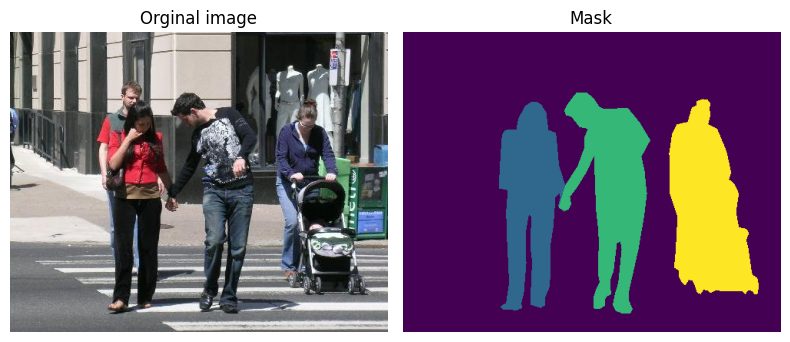

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
input_img_paths = sorted(
    [
        os.path.join(images_root, fname)
        for fname in os.listdir(images_root)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(masks_root, fname)
        for fname in os.listdir(masks_root)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

i = 100
figure, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,8))
ax.ravel()[0].imshow(mpimg.imread(input_img_paths[i]))
ax.ravel()[0].set_title("Orginal image")
ax.ravel()[0].set_axis_off()
ax.ravel()[1].imshow(mpimg.imread(target_img_paths[i]))
ax.ravel()[1].set_title("Mask")
ax.ravel()[1].set_axis_off()

plt.tight_layout()

# So now for our case we're making it compatible with semntic segmantation (i.e. binary mask)

Number of samples: 170


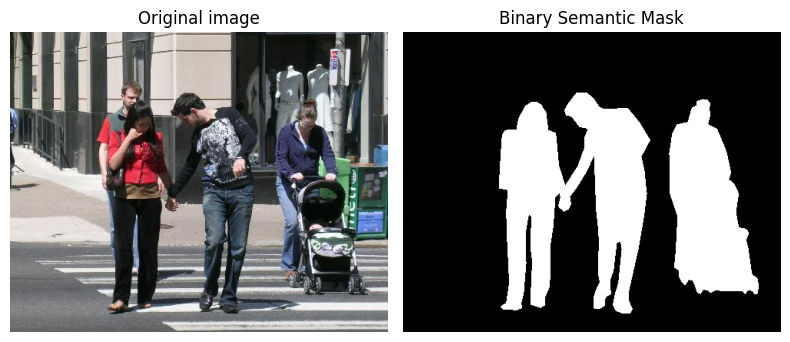

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

input_img_paths = sorted(
    [
        os.path.join(images_root, fname)
        for fname in os.listdir(images_root)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(masks_root, fname)
        for fname in os.listdir(masks_root)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

i = 100

# Load input image
input_img = mpimg.imread(input_img_paths[i])

# Load mask and convert to binary (semantic) mask
target_img = Image.open(target_img_paths[i])
mask_array = np.array(target_img)
binary_mask = (mask_array > 0).astype(np.uint8)  # All person pixels = 1, background = 0

# Display
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
ax[0].imshow(input_img)
ax[0].set_title("Original image")
ax[0].axis('off')

ax[1].imshow(binary_mask, cmap='gray')  # Use grayscale for binary
ax[1].set_title("Binary Semantic Mask")
ax[1].axis('off')

plt.tight_layout()
plt.show()


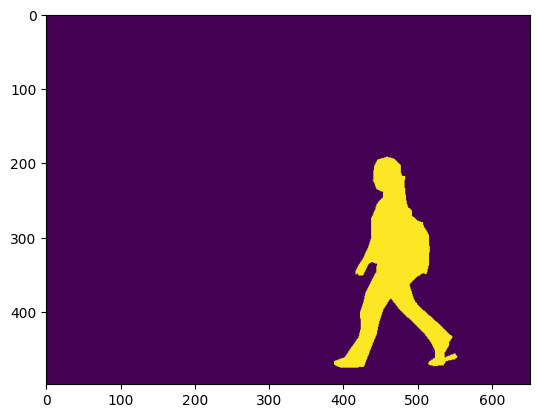

In [ ]:
target_img = Image.open(target_img_paths[12])
mask_array = np.array(target_img)
binary_mask = (mask_array > 0).astype(np.uint8)
mask = Image.fromarray(binary_mask * 255)
plt.imshow(mask)
# plt.imshow(binary_mask)

# type(binary_mask),binary_mask.shape

# **Preparing dataset for training**

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as  np
from torchvision.transforms import ToTensor
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision import transforms


def read_mask(mask_path):
  target_img = Image.open(mask_path)
  mask_array = np.array(target_img)
  binary_mask = (mask_array > 0).astype(np.uint8)
  return binary_mask


TARGET_SIZE = (224, 224)

spatial_transforms = A.Compose([
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1], interpolation=cv2.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
], additional_targets={'mask': 'mask'})

intensity_transforms = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
])

final_transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


class ImageMaskDataset(Dataset):
    """
    PyTorch Dataset to load images and their corresponding masks.
    """
    def __init__(self, image_root, mask_root, transform=None,mask_transform=None):
        self.image_root = image_root
        self.mask_root = mask_root
        self.transform = transform
        self.mask_transform=mask_transform
        # Get list of image files
        self.image_files = sorted(os.listdir(image_root))

        # Get set of mask filenames (for checking availability)
        self.mask_filenames = {os.path.splitext(f)[0] for f in os.listdir(mask_root)}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        mask_filename = os.path.splitext(img_filename)[0] + "_mask.png"
        img_path = os.path.join(self.image_root, img_filename)
        mask_path = os.path.join(self.mask_root, mask_filename)

        image = Image.open(img_path).convert("RGB")
        image=np.array(image)

        mask=read_mask(mask_path)

        transformed = spatial_transforms(image=image, mask=mask)
        image, mask = transformed["image"], transformed["mask"]

            # Apply intensity transforms (only on image)
        image = intensity_transforms(image=image)["image"]

            # Normalize & convert to tensor
        image = final_transforms(image=image)["image"]
        mask = ToTensorV2()(image=mask)["image"]  # (1, 224, 224)

        return image, mask, img_filename

def apply_mask(image, mask):
    """
    Apply mask on the image to remove background.
    """
    image_np = np.array(image)  # Convert to numpy array (H, W, C)
    mask_np = np.array(mask)    # Convert to numpy array (H, W)

    # Normalize mask to [0, 1]
    if mask_np.max() > 1.0:
      mask_np = mask_np / 255.0
    # mask_np = mask_np / 255.0

    # Expand dimensions of mask to match image shape (H, W, C)
    mask_np = np.expand_dims(mask_np, axis=-1)

    # Apply mask (element-wise multiplication)
    masked_image = (image_np * mask_np).astype(np.uint8)

    return masked_image

def visualize_sample(dataset, idx):
    """
    Visualize an image, its mask, and the masked image side by side.
    """
    image, mask, filename = dataset[idx]

    # Convert tensors to PIL images for visualization
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
        mask = mask.squeeze().numpy()  # Remove channel dim if present

    masked_image = apply_mask(image, mask)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Original Image: {filename}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(masked_image)
    plt.title("Masked Image (BG Removed)")
    plt.axis("off")

    plt.show()
# Example usage:

images_root=os.path.join(path,'PennFudanPed/PNGImages')
masks_root=os.path.join(path,'PennFudanPed/PedMasks')
# dataset = ImageMaskDataset(images_root, masks_root,transform=resnet_transform,mask_transform=resnet_transform_mask)
dataset = ImageMaskDataset(images_root, masks_root,transform=None,mask_transform=None)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-6-cd5b75e95b9d>:52: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [ ]:
mask=dataset[0][1]

mask.shape,type(mask)

(torch.Size([1, 224, 224]), torch.Tensor)

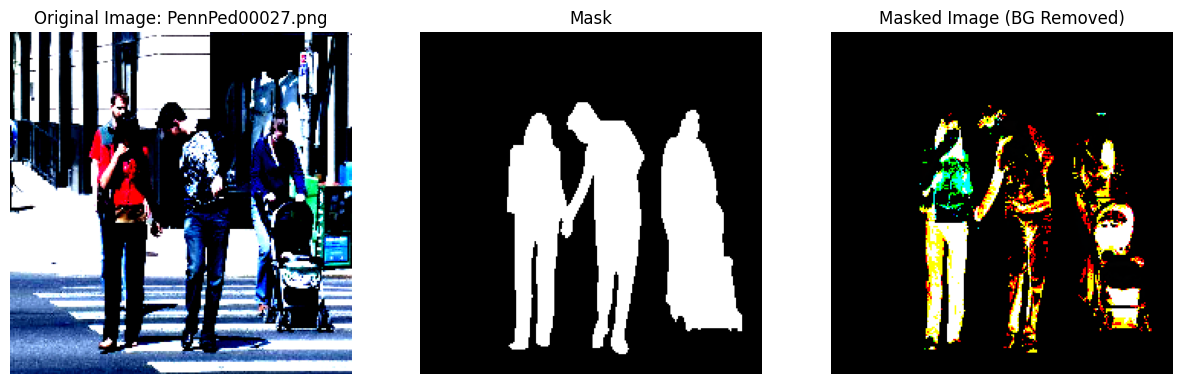

In [ ]:
#display
ind=100
visualize_sample(dataset, ind)

In [ ]:
from torch.utils.data import DataLoader, random_split


# Define split ratios
train_ratio, val_ratio, test_ratio = 0.9, 0.05, 0.05
total_size = len(dataset)

train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size  # Ensures all data is used

# Split dataset
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2)

len(train_loader),len(val_loader),len(test_loader)
print(f'''
dataset lengtg: {len(dataset)}
train_set length: {len(train_set)}
val_set length: {len(val_set)}
test_set length: {len(test_set)}
''')


dataset lengtg: 170
train_set length: 153
val_set length: 8
test_set length: 9



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np

def dice_score(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def visualize_predictions(model, images, masks, preds, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0))
        axes[i, 0].set_title("Original Image")

        axes[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")

        axes[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")

    plt.show()

def train_model(model, train_loader, val_loader, num_epochs=20, device='cuda'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_dice, train_iou = 0, 0, 0

        for batch_idx, (images, masks, file_name) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            masks = masks.float()
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_dice += dice_score(outputs, masks).item()
            train_iou += iou_score(outputs, masks).item()

            if (batch_idx + 1) % 1 == 0:
              print(f"Batch {batch_idx+1}/{len(train_loader)}: avg_IoU= {train_iou/(batch_idx+1)}   avg_dice= {train_dice/(batch_idx+1)}")
            torch.cuda.empty_cache()

        # Validation Step
        model.eval()
        val_loss, val_dice, val_iou = 0, 0, 0
        with torch.no_grad():
            for images, masks,paths in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                masks = masks.float()
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_dice += dice_score(outputs, masks).item()
                val_iou += iou_score(outputs, masks).item()

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss/len(train_loader):.4f}, Train Dice {train_dice/len(train_loader):.4f}, Train IoU {train_iou/len(train_loader):.4f}")
        print(f"                 Val Loss {val_loss/len(val_loader):.4f}, Val Dice {val_dice/len(val_loader):.4f}, Val IoU {val_iou/len(val_loader):.4f}")



In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train_model(model, train_loader, val_loader, num_epochs=10, device=device)

Using device: cuda
Batch 1/10: avg_IoU= 0.0003179766936227679   avg_dice= 0.0006357512320391834
Batch 2/10: avg_IoU= 0.0001589883498869253   avg_dice= 0.00031787561909513303
Batch 3/10: avg_IoU= 0.00010599223605123056   avg_dice= 0.00021191708219003573
Batch 4/10: avg_IoU= 7.94941788209414e-05   avg_dice= 0.00015893781342504526
Batch 5/10: avg_IoU= 6.3595344462768e-05   avg_dice= 0.00012715025214605108
Batch 6/10: avg_IoU= 5.299612166626289e-05   avg_dice= 0.00010595854473566546
Batch 7/10: avg_IoU= 4.542524829264622e-05   avg_dice= 9.082161092356272e-05
Batch 8/10: avg_IoU= 3.9747093262061184e-05   avg_dice= 7.946891056411312e-05
Batch 9/10: avg_IoU= 3.533075047137032e-05   avg_dice= 7.06390325176387e-05
Batch 10/10: avg_IoU= 3.179767655183243e-05   avg_dice= 6.357513039347397e-05
Epoch 1/10: Train Loss 0.5034, Train Dice 0.0001, Train IoU 0.0000
                 Val Loss 0.5780, Val Dice 0.0000, Val IoU 0.0000
Batch 1/10: avg_IoU= 6.546601802326357e-12   avg_dice= 6.546601802326357e-

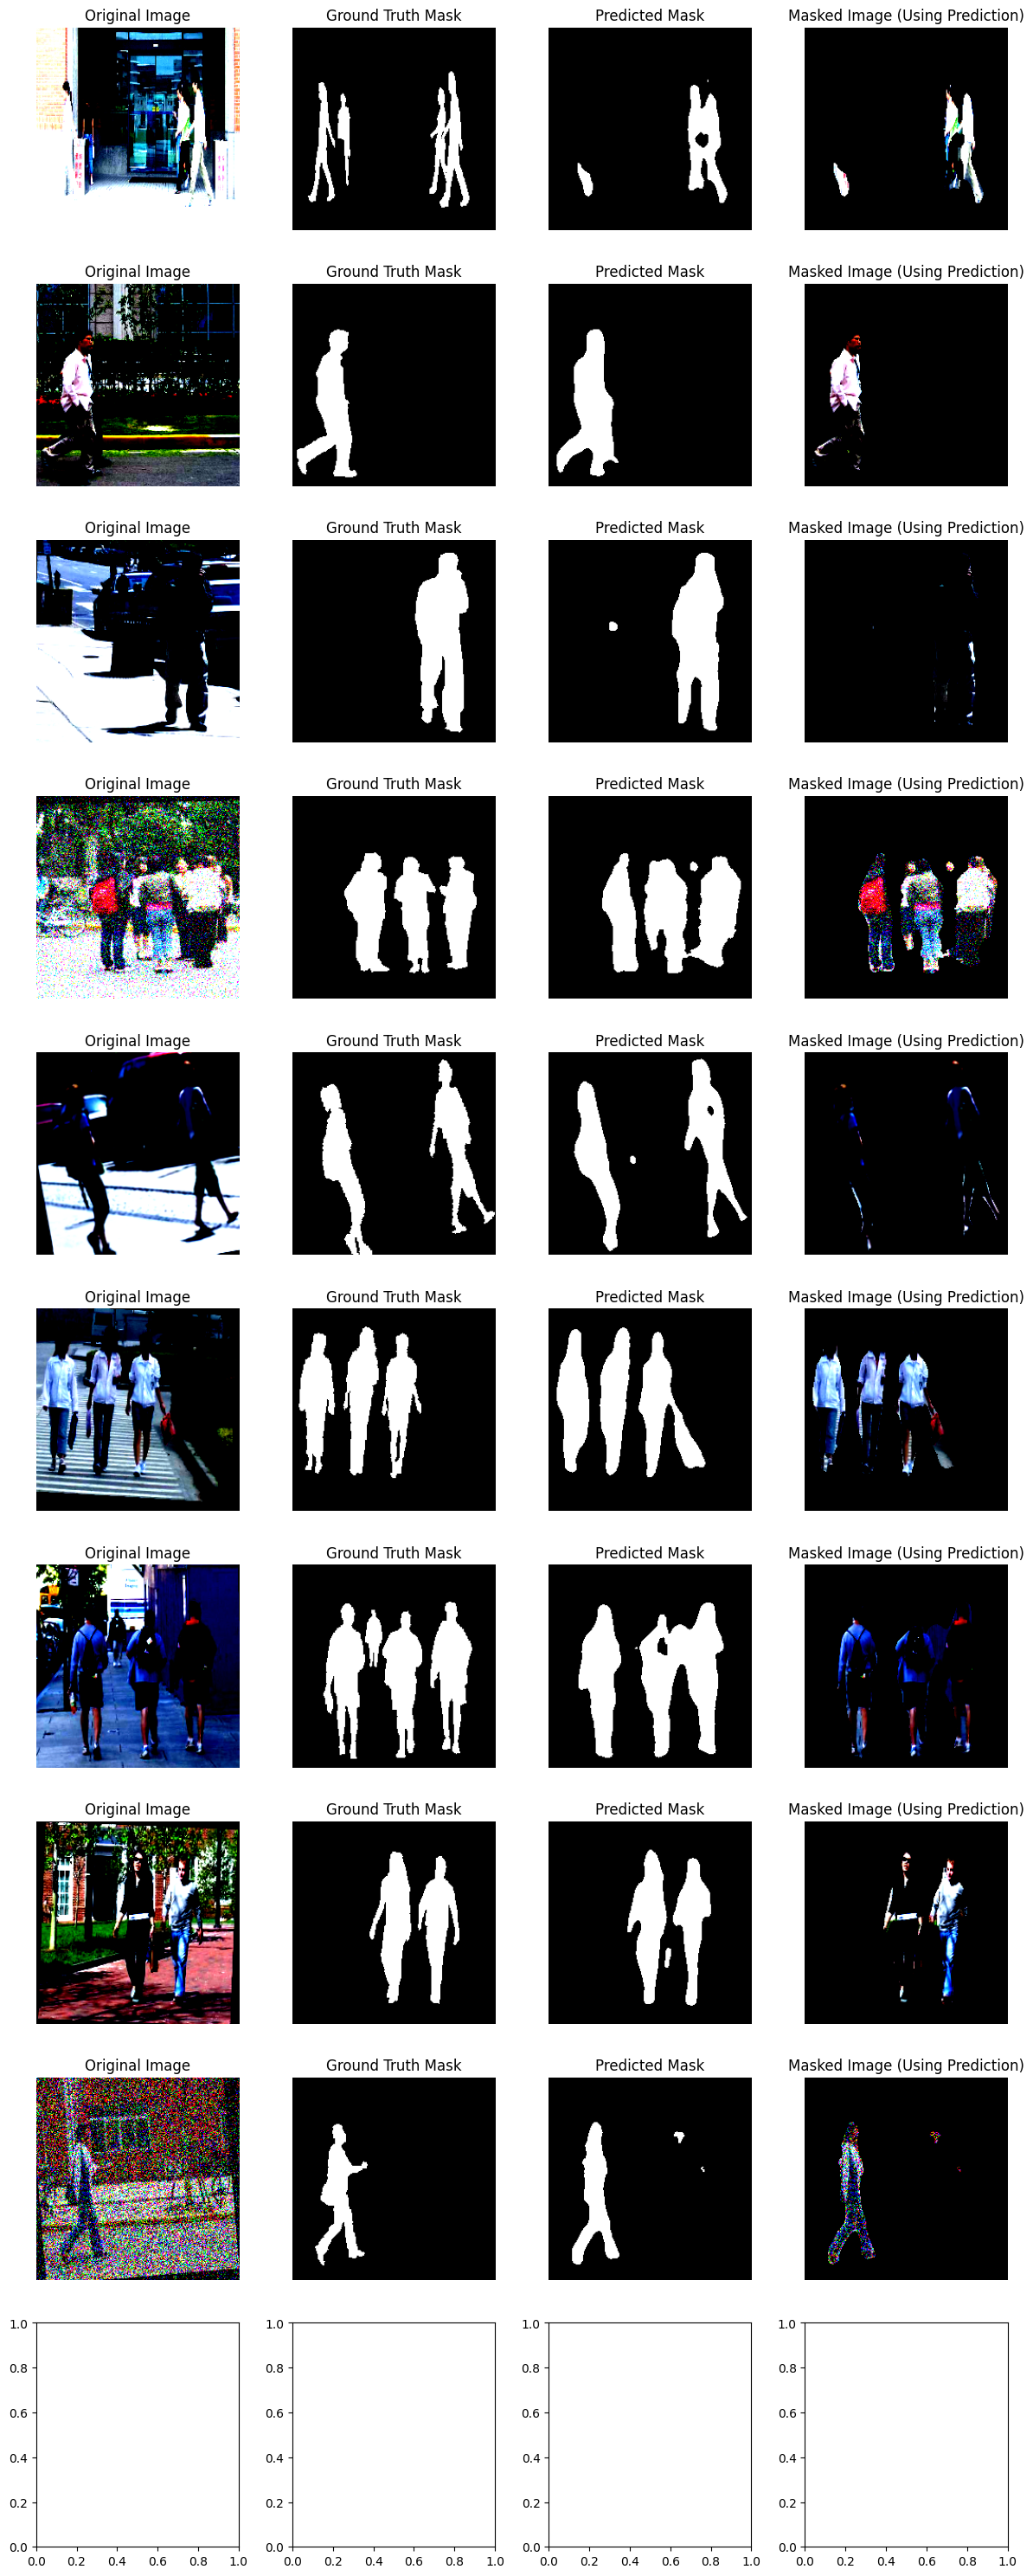

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

def test_model(model, test_loader, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        batch = next(iter(test_loader))  # Get a random batch
        images, masks, _ = batch
        images, masks = images.to(device), masks.to(device)

        # Get model predictions
        preds = model(images)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.6).float()

        indices = random.sample(range(len(images)), min(num_samples, len(images)))

        fig, axes = plt.subplots(num_samples, 4, figsize=(12, num_samples * 3))

        for i, idx in enumerate(indices):
            image = images[idx].cpu().permute(1, 2, 0)
            gt_mask = masks[idx].cpu().squeeze()
            pred_mask = preds[idx].cpu().squeeze()
            masked_image = image * pred_mask.unsqueeze(-1)  # Apply predicted mask

            axes[i, 0].imshow(image)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(gt_mask, cmap='gray')
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

            axes[i, 3].imshow(masked_image)
            axes[i, 3].set_title("Masked Image (Using Prediction)")
            axes[i, 3].axis("off")

        plt.tight_layout()
        plt.show()

# Example usage:
test_model(model, test_loader, device, num_samples=10)


# Saving weights

In [ ]:
weights_checkpoint='weights.pth'
torch.save(model.state_dict(), weights_checkpoint)